In [172]:
import pandas as pd
from matplotlib import pyplot as plt
from pipeline.acquisition import load_sisfall_data
from pipeline.preprocessing import change_activity_duration
from pipeline.preprocessing import change_activity_sampling
from pipeline.feature_extraction import extract_features
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [173]:
dataset_folder = "datasets/SisFall_dataset/"
models_output_folder = 'models/'
uma_dataset_folder = "datasets/output_uma"
combined_dataset_folder = "datasets/combined_dataset"


INCLUDE_GYROSCOPE = False

if INCLUDE_GYROSCOPE:
    sensors =  [0, 1, 2, 3, 4, 5]
else:
    sensors = [0, 1, 2]

should_load_sisfall_data = False

ignored_subjects = []
duration = 12000
frequency = 200

should_save_models = True

In [174]:
def split_data_into_segments(data, min_duration_seconds=12, frequency=200):
    """
    Split time-indexed sensor data into separate segments with minimum duration requirement.
    
    Parameters:
    data: DataFrame with time index and sensor columns (acc_x, acc_y, acc_z)
    min_duration_seconds: Minimum duration in seconds for each segment
    frequency: Sampling frequency (Hz)
    
    Returns:
    list: List of DataFrames, each containing a segment of the data
    """
    min_samples = min_duration_seconds * frequency
    total_samples = len(data)
    
    # If data is shorter than minimum, return the whole data
    if total_samples < min_samples:
        print(f"Data too short ({total_samples} samples < {min_samples} required). Returning whole data.")
        return [data]
    
    # Calculate how many segments we can create
    num_segments = total_samples // min_samples
    
    segments = []
    
    # Split into equal segments
    for segment_idx in range(num_segments):
        start_idx = segment_idx * min_samples
        end_idx = start_idx + min_samples
        
        segment = data.iloc[start_idx:end_idx].copy()
        segments.append(segment)
    
    print(f"Original data length: {total_samples} samples ({total_samples/frequency:.1f} seconds)")
    print(f"Created {len(segments)} segments of {min_samples} samples ({min_duration_seconds} seconds) each")
    
    return segments



In [175]:
raw_sisfall_dataset = pd.read_pickle(f"{combined_dataset_folder}/sisfall_raw_dataset.pkl")

In [176]:
raw_sisfall_dataset['data'][0]

,acc_x,acc_y,acc_z
2000-01-01 00:00:05.000,-0.003906,-0.886719,-0.421875
2000-01-01 00:00:05.005,-0.019531,-0.859375,-0.398438
2000-01-01 00:00:05.010,-0.046875,-0.820312,-0.390625
2000-01-01 00:00:05.015,-0.062500,-0.808594,-0.386719
2000-01-01 00:00:05.020,-0.082031,-0.824219,-0.351562
...,...,...,...
2000-01-01 00:00:14.975,0.027344,-0.953125,0.121094
2000-01-01 00:00:14.980,0.042969,-0.968750,0.113281
2000-01-01 00:00:14.985,0.042969,-0.968750,0.105469
2000-01-01 00:00:14.990,0.035156,-0.968750,0.121094


In [177]:
def read_file_earpiece(file_path, sensors_axes):
    """
    Reads the data from an activity and convert them into a DataFrame with a corresponding time series to the frequency
    of the sensor.

    :param file_path: the path of the file containing the data of the activity
    :param sensors_axes: the data from which sensors' axes is wanted
    :return: a DataFrame containing the data for one activity
    """

    # Reads the file
    data = pd.read_csv(file_path)
    
    # Selects sensors axes
    data = data.iloc[:, sensors_axes]
    
    # Create time index
    index = pd.date_range('1/1/2000', periods=len(data), freq='5ms')
    data.set_index(index, inplace=True)

    return data


In [178]:
new_read = read_file_earpiece('datasets/earpiece/walking_10.csv', [3, 4, 5]).rename(columns={'X': 'acc_x', 'Y': 'acc_y', 'Z': 'acc_z'})
new_read

,acc_x,acc_y,acc_z
2000-01-01 00:00:00.000,-0.967285,0.256836,-0.141602
2000-01-01 00:00:00.005,-0.967285,0.260254,-0.147949
2000-01-01 00:00:00.010,-0.971191,0.251953,-0.142090
2000-01-01 00:00:00.015,-0.974609,0.264648,-0.149414
2000-01-01 00:00:00.020,-0.977539,0.269531,-0.149902
...,...,...,...
2000-01-01 00:00:26.975,-0.999023,0.188965,-0.101074
2000-01-01 00:00:26.980,-1.010254,0.187988,-0.096191
2000-01-01 00:00:26.985,-1.011719,0.191895,-0.092773
2000-01-01 00:00:26.990,-1.019043,0.195312,-0.092773


In [179]:
# Example usage with your earpiece data:
segments = split_data_into_segments(new_read, min_duration_seconds=12, frequency=200)

# Now you can process each segment
for i, segment in enumerate(segments):
    print(f"\nSegment {i+1}:")
    print(f"Shape: {segment.shape}")
    print(f"Time range: {segment.index[0]} to {segment.index[-1]}")
    print(segment.head(3))

Original data length: 5400 samples (27.0 seconds)
Created 2 segments of 2400 samples (12 seconds) each

Segment 1:
Shape: (2400, 3)
Time range: 2000-01-01 00:00:00 to 2000-01-01 00:00:11.995000
                            acc_x     acc_y     acc_z
2000-01-01 00:00:00.000 -0.967285  0.256836 -0.141602
2000-01-01 00:00:00.005 -0.967285  0.260254 -0.147949
2000-01-01 00:00:00.010 -0.971191  0.251953 -0.142090

Segment 2:
Shape: (2400, 3)
Time range: 2000-01-01 00:00:12 to 2000-01-01 00:00:23.995000
                            acc_x     acc_y     acc_z
2000-01-01 00:00:12.000 -0.826172  0.250000 -0.237305
2000-01-01 00:00:12.005 -0.819824  0.252441 -0.243164
2000-01-01 00:00:12.010 -0.810547  0.257324 -0.235352


In [180]:
segments[0]

,acc_x,acc_y,acc_z
2000-01-01 00:00:00.000,-0.967285,0.256836,-0.141602
2000-01-01 00:00:00.005,-0.967285,0.260254,-0.147949
2000-01-01 00:00:00.010,-0.971191,0.251953,-0.142090
2000-01-01 00:00:00.015,-0.974609,0.264648,-0.149414
2000-01-01 00:00:00.020,-0.977539,0.269531,-0.149902
...,...,...,...
2000-01-01 00:00:11.975,-0.860352,0.216797,-0.232422
2000-01-01 00:00:11.980,-0.849121,0.223633,-0.241211
2000-01-01 00:00:11.985,-0.840820,0.226074,-0.233887
2000-01-01 00:00:11.990,-0.835938,0.238770,-0.232422


In [181]:
# prepared_walking_data = change_activity_duration(new_read, 10000)
# prepared_walking_data = change_activity_sampling(new_read, 200)
# prepared_walking_data = prepared_walking_data.rename(columns={'X': 'acc_x', 'Y': 'acc_y', 'Z': 'acc_z'})

In [182]:
activity_label = 'walking'  # or replace with a list if you have multiple labels

# Build the final dataframe
df_segments = pd.DataFrame({
    'class': [activity_label] * len(segments),
    'data': segments
})

df_segments

,class,data
0,walking,acc_x acc_y ...
1,walking,acc_x acc_y ...


In [183]:
prepared_walking_data = segments

In [184]:
prepared_walking_data

[                            acc_x     acc_y     acc_z
 2000-01-01 00:00:00.000 -0.967285  0.256836 -0.141602
 2000-01-01 00:00:00.005 -0.967285  0.260254 -0.147949
 2000-01-01 00:00:00.010 -0.971191  0.251953 -0.142090
 2000-01-01 00:00:00.015 -0.974609  0.264648 -0.149414
 2000-01-01 00:00:00.020 -0.977539  0.269531 -0.149902
 ...                           ...       ...       ...
 2000-01-01 00:00:11.975 -0.860352  0.216797 -0.232422
 2000-01-01 00:00:11.980 -0.849121  0.223633 -0.241211
 2000-01-01 00:00:11.985 -0.840820  0.226074 -0.233887
 2000-01-01 00:00:11.990 -0.835938  0.238770 -0.232422
 2000-01-01 00:00:11.995 -0.833496  0.237305 -0.233398
 
 [2400 rows x 3 columns],
                             acc_x     acc_y     acc_z
 2000-01-01 00:00:12.000 -0.826172  0.250000 -0.237305
 2000-01-01 00:00:12.005 -0.819824  0.252441 -0.243164
 2000-01-01 00:00:12.010 -0.810547  0.257324 -0.235352
 2000-01-01 00:00:12.015 -0.798340  0.259277 -0.236816
 2000-01-01 00:00:12.020 -0.795410  0

In [185]:
# prepared_walking_data

# plt.figure(figsize=(10, 6))
# plt.plot(prepared_walking_data['acc_x'], label='acc_x')
# plt.plot(prepared_walking_data['acc_y'], label='acc_y')
# plt.plot(prepared_walking_data['acc_z'], label='acc_z')
# plt.title('Walking Earpiece Accelerometer Data')
# plt.xlabel('Sample Index')
# plt.ylabel('Acceleration (g)')
# plt.legend()
# plt.show()

In [186]:
features_list = []
final_df = pd.DataFrame()
for index, row in df_segments.iterrows():
    segment = row['data']
    features = extract_features(segment ,with_magnitude=True)
    features['class'] = row['class']
    features['binary'] = 'adl' if row['class'] != 'fall' else 'fall'
    features_list.append(features)
    final_df = pd.concat(features_list, ignore_index=True)

In [187]:
final_df

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class,binary
0,-0.864919,0.474091,-0.146014,1.014630,0.019046,0.027280,0.017455,0.028476,0.138007,0.165167,...,-0.931763,0.364258,-0.236938,0.924505,-0.770020,0.562988,-0.040039,1.067217,walking,adl
1,-0.873219,0.444271,-0.137213,1.012853,0.020278,0.026771,0.023923,0.023815,0.142400,0.163617,...,-0.947754,0.351440,-0.250122,0.931628,-0.778198,0.542114,-0.033203,1.059022,walking,adl


In [188]:
Y_test_adl = final_df['class']
Y_test_binary = final_df['binary']

X_test = final_df.drop(columns=['class', 'binary'])

In [189]:
X_test

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_acc_z,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc
0,-0.864919,0.474091,-0.146014,1.014630,0.019046,0.027280,0.017455,0.028476,0.138007,0.165167,...,1.018066,1.621040,-0.931763,0.364258,-0.236938,0.924505,-0.770020,0.562988,-0.040039,1.067217
1,-0.873219,0.444271,-0.137213,1.012853,0.020278,0.026771,0.023923,0.023815,0.142400,0.163617,...,1.023926,1.398258,-0.947754,0.351440,-0.250122,0.931628,-0.778198,0.542114,-0.033203,1.059022


In [206]:
rf_model_binary = joblib.load('models/rf_model_combined_binary.pkl')
rf_combined_adl = joblib.load('models/rf_model_combined_adl.pkl')

In [201]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Model: {model.__class__.__name__}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='viridis')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

In [202]:
X_test

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_acc_z,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc
0,-0.864919,0.474091,-0.146014,1.014630,0.019046,0.027280,0.017455,0.028476,0.138007,0.165167,...,1.018066,1.621040,-0.931763,0.364258,-0.236938,0.924505,-0.770020,0.562988,-0.040039,1.067217
1,-0.873219,0.444271,-0.137213,1.012853,0.020278,0.026771,0.023923,0.023815,0.142400,0.163617,...,1.023926,1.398258,-0.947754,0.351440,-0.250122,0.931628,-0.778198,0.542114,-0.033203,1.059022


In [212]:
import numpy as np


def evaluate_model_binary(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Model: {model.__class__.__name__}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique([*y_test, *y_pred]))

    disp.plot(cmap='viridis')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()



In [211]:
rf_model_binary.predict(X_test)

array(['adl', 'adl'], dtype=object)

Model: RandomForestClassifier
Classification Report:
              precision    recall  f1-score   support

         adl       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Confusion Matrix:
Accuracy: 1.0000



/Users/amir/Downloads/fall-detection-master/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


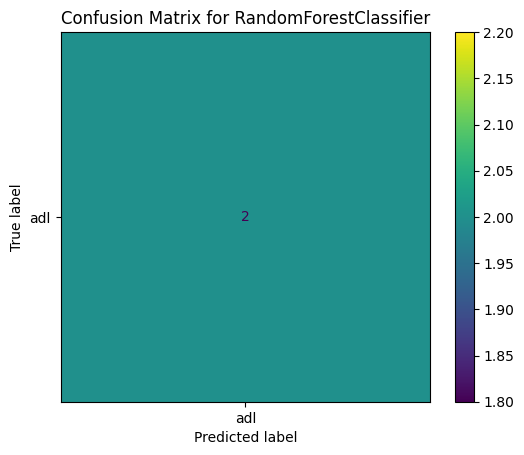

In [213]:
evaluate_model_binary(rf_model_binary, X_test, Y_test_binary)

In [ ]:
# Get the classes that the model was trained on
import numpy as np


model_classes = rf_combined_adl.classes_

# Create a modified evaluate function that handles single-class test data
def evaluate_single_class(model, X_test, y_test):
	y_pred = model.predict(X_test)
	print(f"Model: {model.__class__.__name__}")
	print(f"Predictions: {y_pred}")
	print(f"Actual values: {y_test.values}")
	
	# Calculate accuracy for the predictions
	accuracy = (y_pred == y_test).mean()
	print(f"Accuracy: {accuracy:.4f}")
	
	# Print which ADL class the model predicts for the walking data
	print("\nPrediction distribution:")
	unique_preds, counts = np.unique(y_pred, return_counts=True)
	for pred, count in zip(unique_preds, counts):
		print(f"  {pred}: {count} samples ({count/len(y_pred)*100:.1f}%)")

# Use the modified evaluation function for single-class data
evaluate_single_class(rf_combined_adl, X_test, Y_test)

Model: RandomForestClassifier
Predictions: ['walking' 'walking']
Actual values: ['walking' 'walking']
Accuracy: 1.0000

Prediction distribution:
  walking: 2 samples (100.0%)
